# Train RetinaNet (Backbone = VGG-16)

In [6]:
import tensorflow as tf
import numpy as np
from keras_retinanet import models
from keras_retinanet.preprocessing.csv_generator import CSVGenerator
from keras_retinanet.utils.transform import random_transform_generator
from keras_retinanet.utils.image import random_visual_effect_generator

In [7]:
from keras_retinanet.losses import smooth_l1, focal

In [8]:
import keras_retinanet
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from keras_retinanet import models, losses
from keras_retinanet.models.retinanet import retinanet_bbox
from keras_retinanet.utils.model import freeze as freeze_model
from keras_retinanet.utils.config import read_config_file, parse_anchor_parameters, parse_pyramid_levels
from keras_retinanet.callbacks.eval import Evaluate
from keras_retinanet.callbacks import RedirectModel
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import SGD

In [9]:
def model_with_weights(model, weights, skip_mismatch):
    if weights is not None:
        model.load_weights(weights, by_name=True, skip_mismatch=skip_mismatch)
    return model

In [10]:
def create_models(backbone_retinanet, num_classes, weights,
                  freeze_backbone=False, lr=1e-5, config=None):
    modifier = freeze_model if freeze_backbone else None

    # load anchor parameters, or pass None (so that defaults will be used)
    anchor_params = None
    num_anchors   = None
    pyramid_levels = None
    if config and 'anchor_parameters' in config:
        anchor_params = parse_anchor_parameters(config)
        num_anchors   = anchor_params.num_anchors()
    if config and 'pyramid_levels' in config:
        pyramid_levels = parse_pyramid_levels(config)
    
    training_model = model_with_weights(backbone_retinanet(num_classes, num_anchors=num_anchors, modifier=modifier, pyramid_levels=pyramid_levels), weights=weights, skip_mismatch=True)

    # make prediction model
    prediction_model = retinanet_bbox(model=training_model, anchor_params=anchor_params, pyramid_levels=pyramid_levels)

    # compile model
    training_model.compile(
        loss={
            'regression'    : losses.smooth_l1(),
            'classification': losses.focal()
        },
        optimizer=SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True),
    )
    return training_model, prediction_model


In [11]:
def create_callbacks(training_model, prediction_model, validation_generator, model_path, log_file):
    callbacks = []
    tensorboard_callback = None
    evaluation = Evaluate(validation_generator, tensorboard=tensorboard_callback, weighted_average=True)
    evaluation = RedirectModel(evaluation, prediction_model)
    callbacks.append(evaluation)
    checkpoint = keras.callbacks.ModelCheckpoint(model_path,
                                                verbose=1,
                                                save_best_only=True,
                                                monitor='mAP',
                                                mode='max'
                                                )
    checkpoint = RedirectModel(checkpoint, training_model)
    callbacks.append(checkpoint)
    callbacks.append(keras.callbacks.CSVLogger(log_file))
    callbacks.append(keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,
        verbose=1,
        mode='auto',
        min_delta=0.0001,
        cooldown=0,
        min_lr=0
    ))
    return callbacks

In [12]:
def plot_history(history, fig, subtitle, epochs):
    epoch_list = list(range(1, epochs+1))
    regression_loss = history.history['loss']
    classification_loss = history.history['classification_loss']
    val_regression_loss = history.history['val_regression_loss']
    val_classification_loss = history.history['val_classification_loss']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    val_mAP = history.history['mAP']
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(13, 20))
    f.subplots_adjust(hspace=0.3)
    t = f.suptitle(subtitle, fontsize=17)

   
    ax1.plot(epoch_list, classification_loss, label='Train Classification Loss')
    ax1.plot(epoch_list, val_classification_loss, label='Validation Classification Loss')
    ax1.set_xticks(np.arange(1, epochs + 1, 1))
    ax1.set_ylim(0, 1.3)
    ax1.set_ylabel('Focal Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Classification Loss')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, regression_loss, label='Train Regression Loss')
    ax2.plot(epoch_list, val_regression_loss, label='Validation Regression Loss')
    ax2.set_xticks(np.arange(1, epochs + 1, 1))
    ax2.set_ylim(0, 3)
    ax2.set_ylabel('Smooth L1 Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Regression Loss')
    l2 = ax2.legend(loc="best")

    ax3.plot(epoch_list, loss, label='Train Loss')
    ax3.plot(epoch_list, val_loss, label='Validation Loss')
    ax3.set_xticks(np.arange(1, epochs + 1, 1))
    ax3.set_ylim(0, 4)
    ax3.set_ylabel('Loss')
    ax3.set_xlabel('Epoch')
    ax3.set_title('Total Loss (Classification Loss + Regression Loss)')
    l3 = ax3.legend(loc="best")
    
    ax4.plot(epoch_list, val_mAP, label='Validation AP')
    ax4.set_xticks(np.arange(1, epochs+1, 1))
    ax4.set_ylim(0,1)
    ax4.set_ylabel('AP')
    ax4.set_xlabel('Epoch')
    ax4.set_title('Average Precision (AP)')
    l4 = ax4.legend(loc="best")
    
    plt.savefig(fig)
    

In [13]:
np.random.seed(1) 
tf.random.set_seed(1)

In [14]:
tf.test.is_built_with_cuda()  

False

In [15]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU'))) #print no of GPU device

Num GPUs Available:  0


In [17]:
backbone = models.backbone('vgg16')
weights = backbone.download_imagenet()

ModuleNotFoundError: No module named 'keras_retinanet.models.backbone'

In [20]:
import keras_retinanet
from keras_retinanet.models import backbone

backbone = backbone.vgg16()
weights = backbone.download_imagenet()

AttributeError: 'function' object has no attribute 'vgg16'

In [12]:
train_generator = CSVGenerator(
    csv_data_file=r'C:\Users\Asus\Desktop\PG Project\Nandhini\Phase 2\Dataset\Kvasir-SEG\train.csv',
    csv_class_file=r'C:\Users\Asus\Desktop\PG Project\Nandhini\Phase 2\Dataset\Kvasir-SEG\class.csv',
    no_resize = True,
    preprocess_image  = backbone.preprocess_image
)

val_generator = CSVGenerator(
    csv_data_file=r'C:\Users\Asus\Desktop\PG Project\Nandhini\Phase 2\Dataset\Kvasir-SEG\valid.csv',
    csv_class_file=r'C:\Users\Asus\Desktop\PG Project\Nandhini\Phase 2\Dataset\Kvasir-SEG\class.csv',
    no_resize = True,
    preprocess_image  = backbone.preprocess_image
)

In [13]:
lr = 1e-3
epochs = 2
steps = 10

## Without Data Augmentation

In [15]:
training_model, prediction_model = create_models(backbone_retinanet=backbone.retinanet,
                                                num_classes=1,
                                                weights=weights,
                                                freeze_backbone=True,
                                                lr=lr)

C:\Users\Asus\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


C:\Users\Asus\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
log_file = r'C:\Users\Asus\Desktop\PG Project\Nandhini\Phase 2\Github code\polyp_detection_retinanet-main\result\retinanet_resnet50_log.csv'
model_path = r'C:\Users\Asus\Downloads\ResNet-50-model.keras.h5'
callback = create_callbacks(training_model, prediction_model, val_generator, model_path, log_file)

In [17]:
prediction_model.summary()

Model: "retinanet-bbox"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1 (Conv2D)                 (None, None, None,   9408        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, None, None,   256         ['conv1[0][0]']                  
                                64)                                                  

                                                                                                  
 res2b (Add)                    (None, None, None,   0           ['bn2b_branch2c[0][0]',          
                                256)                              'res2a_relu[0][0]']             
                                                                                                  
 res2b_relu (Activation)        (None, None, None,   0           ['res2b[0][0]']                  
                                256)                                                              
                                                                                                  
 res2c_branch2a (Conv2D)        (None, None, None,   16384       ['res2b_relu[0][0]']             
                                64)                                                               
                                                                                                  
 bn2c_bran

 ion)                           128)                                                              
                                                                                                  
 res3b_branch2a_relu (Activatio  (None, None, None,   0          ['bn3b_branch2a[0][0]']          
 n)                             128)                                                              
                                                                                                  
 padding3b_branch2b (ZeroPaddin  (None, None, None,   0          ['res3b_branch2a_relu[0][0]']    
 g2D)                           128)                                                              
                                                                                                  
 res3b_branch2b (Conv2D)        (None, None, None,   147456      ['padding3b_branch2b[0][0]']     
                                128)                                                              
          

 res3d_branch2c (Conv2D)        (None, None, None,   65536       ['res3d_branch2b_relu[0][0]']    
                                512)                                                              
                                                                                                  
 bn3d_branch2c (BatchNormalizat  (None, None, None,   2048       ['res3d_branch2c[0][0]']         
 ion)                           512)                                                              
                                                                                                  
 res3d (Add)                    (None, None, None,   0           ['bn3d_branch2c[0][0]',          
                                512)                              'res3c_relu[0][0]']             
                                                                                                  
 res3d_relu (Activation)        (None, None, None,   0           ['res3d[0][0]']                  
          

                                                                                                  
 res4c_branch2a (Conv2D)        (None, None, None,   262144      ['res4b_relu[0][0]']             
                                256)                                                              
                                                                                                  
 bn4c_branch2a (BatchNormalizat  (None, None, None,   1024       ['res4c_branch2a[0][0]']         
 ion)                           256)                                                              
                                                                                                  
 res4c_branch2a_relu (Activatio  (None, None, None,   0          ['bn4c_branch2a[0][0]']          
 n)                             256)                                                              
                                                                                                  
 padding4c

 ion)                           256)                                                              
                                                                                                  
 res4e_branch2b_relu (Activatio  (None, None, None,   0          ['bn4e_branch2b[0][0]']          
 n)                             256)                                                              
                                                                                                  
 res4e_branch2c (Conv2D)        (None, None, None,   262144      ['res4e_branch2b_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 bn4e_branch2c (BatchNormalizat  (None, None, None,   4096       ['res4e_branch2c[0][0]']         
 ion)                           1024)                                                             
          

 res5a (Add)                    (None, None, None,   0           ['bn5a_branch2c[0][0]',          
                                2048)                             'bn5a_branch1[0][0]']           
                                                                                                  
 res5a_relu (Activation)        (None, None, None,   0           ['res5a[0][0]']                  
                                2048)                                                             
                                                                                                  
 res5b_branch2a (Conv2D)        (None, None, None,   1048576     ['res5a_relu[0][0]']             
                                512)                                                              
                                                                                                  
 bn5b_branch2a (BatchNormalizat  (None, None, None,   2048       ['res5b_branch2a[0][0]']         
 ion)     

                                                                                                  
 P4_upsampled (UpsampleLike)    (None, None, None,   0           ['P4_merged[0][0]',              
                                256)                              'res3d_relu[0][0]']             
                                                                                                  
 C3_reduced (Conv2D)            (None, None, None,   131328      ['res3d_relu[0][0]']             
                                256)                                                              
                                                                                                  
 P6 (Conv2D)                    (None, None, None,   4718848     ['res5c_relu[0][0]']             
                                256)                                                              
                                                                                                  
 P3_merged

In [18]:
training_model.summary()

Model: "retinanet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1 (Conv2D)                 (None, None, None,   9408        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, None, None,   256         ['conv1[0][0]']                  
                                64)                                                       

                                                                                                  
 res2b (Add)                    (None, None, None,   0           ['bn2b_branch2c[0][0]',          
                                256)                              'res2a_relu[0][0]']             
                                                                                                  
 res2b_relu (Activation)        (None, None, None,   0           ['res2b[0][0]']                  
                                256)                                                              
                                                                                                  
 res2c_branch2a (Conv2D)        (None, None, None,   16384       ['res2b_relu[0][0]']             
                                64)                                                               
                                                                                                  
 bn2c_bran

 ion)                           128)                                                              
                                                                                                  
 res3b_branch2a_relu (Activatio  (None, None, None,   0          ['bn3b_branch2a[0][0]']          
 n)                             128)                                                              
                                                                                                  
 padding3b_branch2b (ZeroPaddin  (None, None, None,   0          ['res3b_branch2a_relu[0][0]']    
 g2D)                           128)                                                              
                                                                                                  
 res3b_branch2b (Conv2D)        (None, None, None,   147456      ['padding3b_branch2b[0][0]']     
                                128)                                                              
          

 res3d_branch2c (Conv2D)        (None, None, None,   65536       ['res3d_branch2b_relu[0][0]']    
                                512)                                                              
                                                                                                  
 bn3d_branch2c (BatchNormalizat  (None, None, None,   2048       ['res3d_branch2c[0][0]']         
 ion)                           512)                                                              
                                                                                                  
 res3d (Add)                    (None, None, None,   0           ['bn3d_branch2c[0][0]',          
                                512)                              'res3c_relu[0][0]']             
                                                                                                  
 res3d_relu (Activation)        (None, None, None,   0           ['res3d[0][0]']                  
          

                                                                                                  
 res4c_branch2a (Conv2D)        (None, None, None,   262144      ['res4b_relu[0][0]']             
                                256)                                                              
                                                                                                  
 bn4c_branch2a (BatchNormalizat  (None, None, None,   1024       ['res4c_branch2a[0][0]']         
 ion)                           256)                                                              
                                                                                                  
 res4c_branch2a_relu (Activatio  (None, None, None,   0          ['bn4c_branch2a[0][0]']          
 n)                             256)                                                              
                                                                                                  
 padding4c

 ion)                           256)                                                              
                                                                                                  
 res4e_branch2b_relu (Activatio  (None, None, None,   0          ['bn4e_branch2b[0][0]']          
 n)                             256)                                                              
                                                                                                  
 res4e_branch2c (Conv2D)        (None, None, None,   262144      ['res4e_branch2b_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 bn4e_branch2c (BatchNormalizat  (None, None, None,   4096       ['res4e_branch2c[0][0]']         
 ion)                           1024)                                                             
          

 res5a (Add)                    (None, None, None,   0           ['bn5a_branch2c[0][0]',          
                                2048)                             'bn5a_branch1[0][0]']           
                                                                                                  
 res5a_relu (Activation)        (None, None, None,   0           ['res5a[0][0]']                  
                                2048)                                                             
                                                                                                  
 res5b_branch2a (Conv2D)        (None, None, None,   1048576     ['res5a_relu[0][0]']             
                                512)                                                              
                                                                                                  
 bn5b_branch2a (BatchNormalizat  (None, None, None,   2048       ['res5b_branch2a[0][0]']         
 ion)     

                                                                                                  
 P4_upsampled (UpsampleLike)    (None, None, None,   0           ['P4_merged[0][0]',              
                                256)                              'res3d_relu[0][0]']             
                                                                                                  
 C3_reduced (Conv2D)            (None, None, None,   131328      ['res3d_relu[0][0]']             
                                256)                                                              
                                                                                                  
 P6 (Conv2D)                    (None, None, None,   4718848     ['res5c_relu[0][0]']             
                                256)                                                              
                                                                                                  
 P3_merged

In [19]:
history = training_model.fit(
    x=train_generator,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    callbacks=callback,
    steps_per_epoch=steps
)

Epoch 1/2
10/10 [==============================] - ETA: 0s - loss: 3.9873 - regression_loss: 2.8583 - classification_loss: 1.1290

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:19 Time:  0:02:19
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 1: mAP improved from -inf to 0.00000, saving model to C:\Users\Asus\Downloads\ResNet-50-model.keras.h5
10/10 [==============================] - 315s 34s/step - loss: 3.9873 - regression_loss: 2.8583 - classification_loss: 1.1290 - val_loss: 3.9376 - val_regression_loss: 2.8100 - val_classification_loss: 1.1276 - mAP: 0.0000e+00 - lr: 0.0010
Epoch 2/2
10/10 [==============================] - ETA: 0s - loss: 4.0401 - regression_loss: 2.9141 - classification_loss: 1.1260

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:21 Time:  0:02:21
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 2: mAP did not improve from 0.00000
10/10 [==============================] - 301s 33s/step - loss: 4.0401 - regression_loss: 2.9141 - classification_loss: 1.1260 - val_loss: 3.9080 - val_regression_loss: 2.7845 - val_classification_loss: 1.1235 - mAP: 0.0000e+00 - lr: 0.0010


In [20]:
print(history)

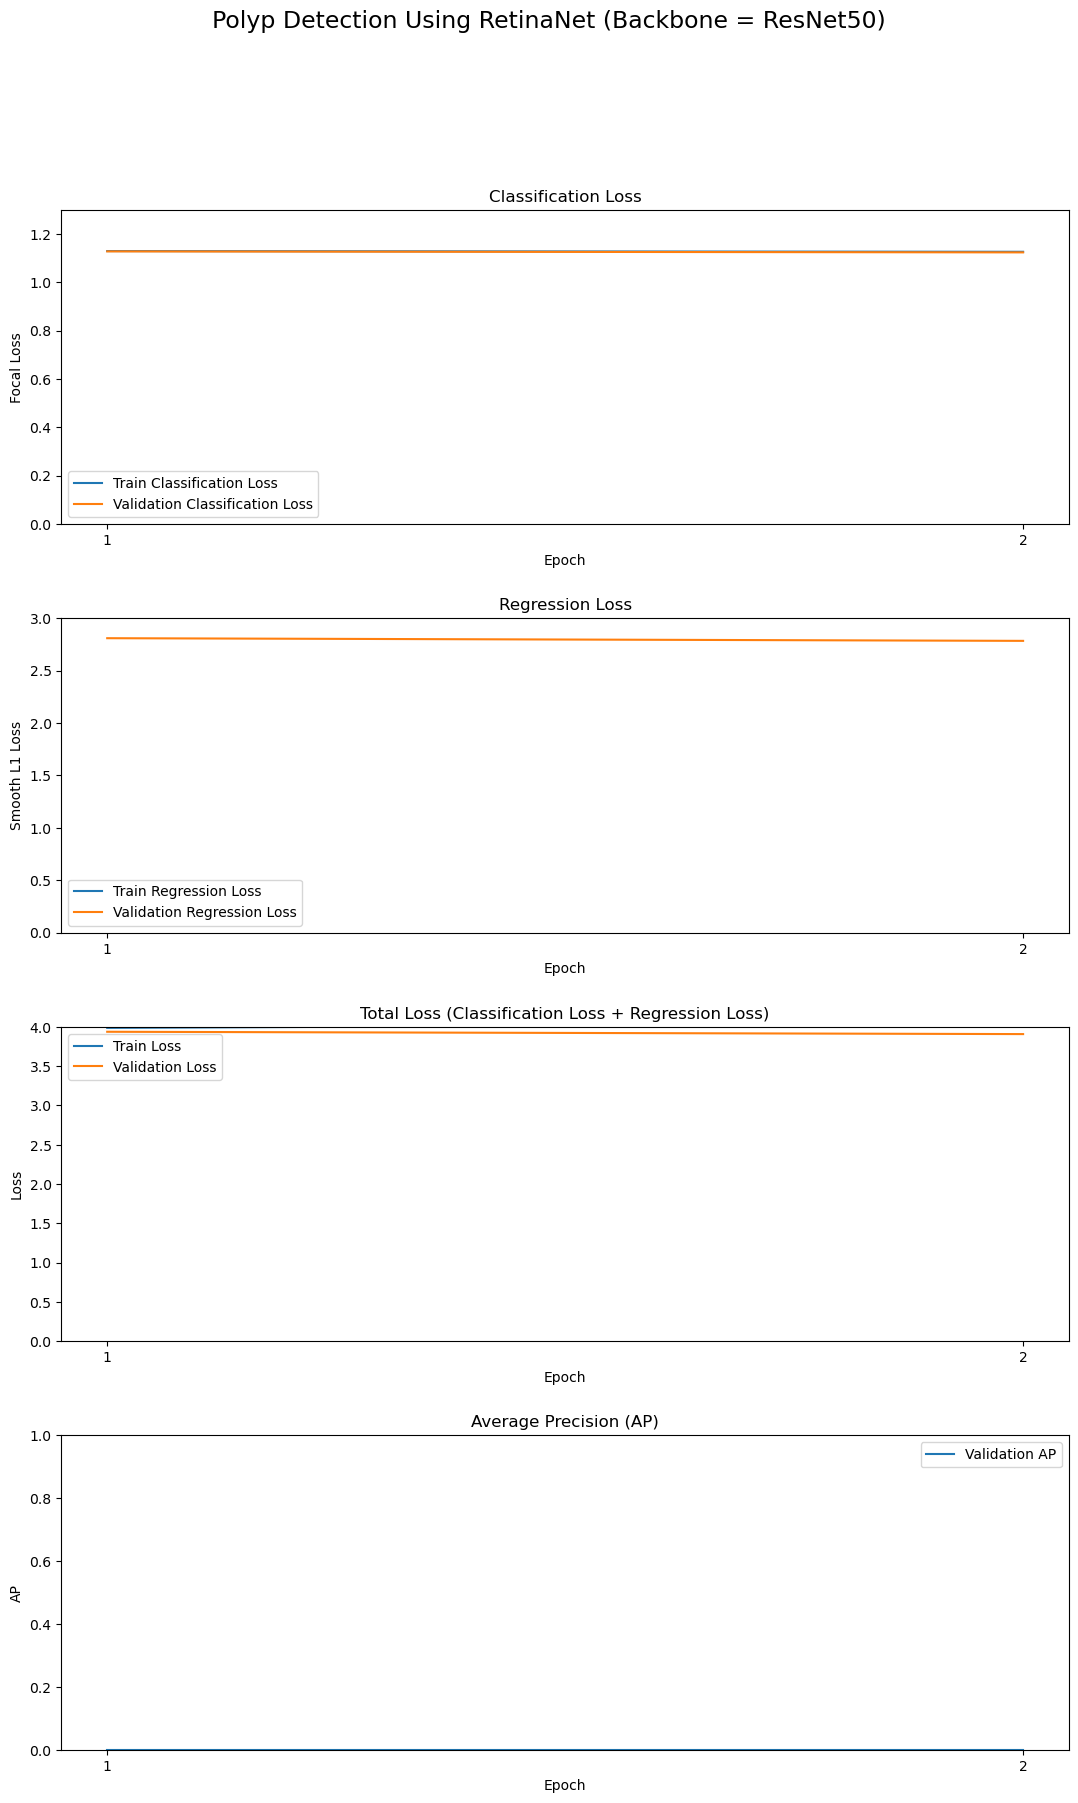

In [21]:
fig = r'C:\Users\Asus\Desktop\retinanet_resnet50.png'
plot_history ( history, fig, 'Polyp Detection Using RetinaNet (Backbone = ResNet50)', epochs)

## With Data Augmentation

In [14]:
training_model_aug, prediction_model_aug = create_models(backbone_retinanet=backbone.retinanet,
                                          num_classes=1,
                                          weights=weights,
                                          freeze_backbone=True,
                                          lr=lr)

C:\Users\Asus\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


C:\Users\Asus\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
transform_generator = random_transform_generator(
            min_rotation=-0.1,
            max_rotation=0.1,
            min_scaling=(0.9, 0.9),
            max_scaling=(1.1, 1.1),
            flip_x_chance=0.5,
            flip_y_chance=0.5,
        )
visual_effect_generator = random_visual_effect_generator(
            contrast_range=(0.9, 1.1),
            brightness_range=(-.1, .1),
        )

In [16]:
train_generator_aug = CSVGenerator(
    csv_data_file= r'C:\Users\Asus\Desktop\PG Project\Nandhini\Phase 2\Dataset\Kvasir-SEG\train.csv',
    csv_class_file=r'C:\Users\Asus\Desktop\PG Project\Nandhini\Phase 2\Dataset\Kvasir-SEG\class.csv',
    no_resize = True,
    preprocess_image  = backbone.preprocess_image,
    transform_generator=transform_generator,
    visual_effect_generator=visual_effect_generator
)

In [17]:
log_file_aug = r'C:\Users\Asus\Desktop\PG Project\Nandhini\Phase 2\Github code\polyp_detection_retinanet-main\result\retinanet_vgg16_aug_log.csv'
model_path_aug = r'C:\Users\Asus\Downloads\ResNet-50-model.keras.h5'
callback_aug = create_callbacks(training_model_aug, prediction_model_aug, val_generator, model_path_aug, log_file_aug)

In [18]:
history_aug = training_model_aug.fit(
                x=train_generator_aug,
                epochs=epochs,
                verbose=1,
                validation_data=val_generator,
                callbacks=callback_aug,
                steps_per_epoch = steps
                )

Epoch 1/24
100/100 [==============================] - ETA: 0s - loss: 3.7276 - regression_loss: 2.6692 - classification_loss: 1.0585

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:25 Time:  0:02:25
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.1005
mAP: 0.1005

Epoch 1: mAP improved from -inf to 0.10049, saving model to C:\Users\Asus\Downloads\ResNet-50-model.keras.h5
100/100 [==============================] - 992s 10s/step - loss: 3.7276 - regression_loss: 2.6692 - classification_loss: 1.0585 - val_loss: 3.2493 - val_regression_loss: 2.5499 - val_classification_loss: 0.6994 - mAP: 0.1005 - lr: 0.0010
Epoch 2/24
100/100 [==============================] - ETA: 0s - loss: 3.1409 - regression_loss: 2.5427 - classification_loss: 0.5982

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:22 Time:  0:02:22
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.1821
mAP: 0.1821

Epoch 2: mAP improved from 0.10049 to 0.18212, saving model to C:\Users\Asus\Downloads\ResNet-50-model.keras.h5
100/100 [==============================] - 582s 6s/step - loss: 3.1409 - regression_loss: 2.5427 - classification_loss: 0.5982 - val_loss: 3.0082 - val_regression_loss: 2.5400 - val_classification_loss: 0.4682 - mAP: 0.1821 - lr: 0.0010
Epoch 3/24
100/100 [==============================] - ETA: 0s - loss: 3.0515 - regression_loss: 2.3871 - classification_loss: 0.6645

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:12 Time:  0:02:12
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 3: mAP did not improve from 0.18212
100/100 [==============================] - 574s 6s/step - loss: 3.0515 - regression_loss: 2.3871 - classification_loss: 0.6645 - val_loss: 3.3368 - val_regression_loss: 2.2222 - val_classification_loss: 1.1147 - mAP: 0.0000e+00 - lr: 0.0010
Epoch 4/24
100/100 [==============================] - ETA: 0s - loss: 3.3719 - regression_loss: 2.2650 - classification_loss: 1.1068

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:07 Time:  0:02:07
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 4: mAP did not improve from 0.18212
100/100 [==============================] - 554s 6s/step - loss: 3.3719 - regression_loss: 2.2650 - classification_loss: 1.1068 - val_loss: 3.2375 - val_regression_loss: 2.1403 - val_classification_loss: 1.0972 - mAP: 0.0000e+00 - lr: 0.0010
Epoch 5/24
100/100 [==============================] - ETA: 0s - loss: 3.1283 - regression_loss: 2.1583 - classification_loss: 0.9700

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:06 Time:  0:02:06
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.1909
mAP: 0.1909

Epoch 5: mAP improved from 0.18212 to 0.19089, saving model to C:\Users\Asus\Downloads\ResNet-50-model.keras.h5
100/100 [==============================] - 535s 5s/step - loss: 3.1283 - regression_loss: 2.1583 - classification_loss: 0.9700 - val_loss: 2.7796 - val_regression_loss: 2.2555 - val_classification_loss: 0.5240 - mAP: 0.1909 - lr: 0.0010
Epoch 6/24
100/100 [==============================] - ETA: 0s - loss: 2.6161 - regression_loss: 2.0187 - classification_loss: 0.5974

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:08 Time:  0:02:08
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.2223
mAP: 0.2223

Epoch 6: mAP improved from 0.19089 to 0.22228, saving model to C:\Users\Asus\Downloads\ResNet-50-model.keras.h5
100/100 [==============================] - 534s 5s/step - loss: 2.6161 - regression_loss: 2.0187 - classification_loss: 0.5974 - val_loss: 2.4130 - val_regression_loss: 1.9312 - val_classification_loss: 0.4818 - mAP: 0.2223 - lr: 0.0010
Epoch 7/24
100/100 [==============================] - ETA: 0s - loss: 2.9350 - regression_loss: 1.8714 - classification_loss: 1.0636

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:06 Time:  0:02:06
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 7: mAP did not improve from 0.22228
100/100 [==============================] - 531s 5s/step - loss: 2.9350 - regression_loss: 1.8714 - classification_loss: 1.0636 - val_loss: 2.9930 - val_regression_loss: 1.9076 - val_classification_loss: 1.0853 - mAP: 0.0000e+00 - lr: 0.0010
Epoch 8/24
100/100 [==============================] - ETA: 0s - loss: 3.0192 - regression_loss: 1.9410 - classification_loss: 1.0782

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:05 Time:  0:02:05
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 8: mAP did not improve from 0.22228
100/100 [==============================] - 540s 5s/step - loss: 3.0192 - regression_loss: 1.9410 - classification_loss: 1.0782 - val_loss: 2.7969 - val_regression_loss: 1.7234 - val_classification_loss: 1.0735 - mAP: 0.0000e+00 - lr: 0.0010
Epoch 9/24
100/100 [==============================] - ETA: 0s - loss: 2.9637 - regression_loss: 1.8958 - classification_loss: 1.0679

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:06 Time:  0:02:06
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 9: mAP did not improve from 0.22228
100/100 [==============================] - 532s 5s/step - loss: 2.9637 - regression_loss: 1.8958 - classification_loss: 1.0679 - val_loss: 2.7898 - val_regression_loss: 1.7296 - val_classification_loss: 1.0602 - mAP: 0.0000e+00 - lr: 0.0010
Epoch 10/24
100/100 [==============================] - ETA: 0s - loss: 2.7372 - regression_loss: 1.7201 - classification_loss: 1.0171

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:08 Time:  0:02:08
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.2717
mAP: 0.2717

Epoch 10: mAP improved from 0.22228 to 0.27170, saving model to C:\Users\Asus\Downloads\ResNet-50-model.keras.h5
100/100 [==============================] - 533s 5s/step - loss: 2.7372 - regression_loss: 1.7201 - classification_loss: 1.0171 - val_loss: 2.5621 - val_regression_loss: 1.8596 - val_classification_loss: 0.7024 - mAP: 0.2717 - lr: 0.0010
Epoch 11/24
100/100 [==============================] - ETA: 0s - loss: 2.3151 - regression_loss: 1.7313 - classification_loss: 0.5839

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:06 Time:  0:02:06
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 11: mAP did not improve from 0.27170

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 534s 5s/step - loss: 2.3151 - regression_loss: 1.7313 - classification_loss: 0.5839 - val_loss: 2.7153 - val_regression_loss: 1.6645 - val_classification_loss: 1.0508 - mAP: 0.0000e+00 - lr: 0.0010
Epoch 12/24
100/100 [==============================] - ETA: 0s - loss: 2.5657 - regression_loss: 1.5154 - classification_loss: 1.0504

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:06 Time:  0:02:06
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 12: mAP did not improve from 0.27170
100/100 [==============================] - 533s 5s/step - loss: 2.5657 - regression_loss: 1.5154 - classification_loss: 1.0504 - val_loss: 2.5604 - val_regression_loss: 1.5097 - val_classification_loss: 1.0507 - mAP: 0.0000e+00 - lr: 1.0000e-04
Epoch 13/24
100/100 [==============================] - ETA: 0s - loss: 2.5016 - regression_loss: 1.4504 - classification_loss: 1.0513

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:10 Time:  0:02:10
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 13: mAP did not improve from 0.27170
100/100 [==============================] - 538s 5s/step - loss: 2.5016 - regression_loss: 1.4504 - classification_loss: 1.0513 - val_loss: 2.5255 - val_regression_loss: 1.4758 - val_classification_loss: 1.0497 - mAP: 0.0000e+00 - lr: 1.0000e-04
Epoch 14/24
100/100 [==============================] - ETA: 0s - loss: 2.4998 - regression_loss: 1.4501 - classification_loss: 1.0497

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:06 Time:  0:02:06
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 14: mAP did not improve from 0.27170
100/100 [==============================] - 535s 5s/step - loss: 2.4998 - regression_loss: 1.4501 - classification_loss: 1.0497 - val_loss: 2.5118 - val_regression_loss: 1.4632 - val_classification_loss: 1.0486 - mAP: 0.0000e+00 - lr: 1.0000e-04
Epoch 15/24
100/100 [==============================] - ETA: 0s - loss: 2.4440 - regression_loss: 1.3963 - classification_loss: 1.0477

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:06 Time:  0:02:06
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 15: mAP did not improve from 0.27170
100/100 [==============================] - 533s 5s/step - loss: 2.4440 - regression_loss: 1.3963 - classification_loss: 1.0477 - val_loss: 2.5186 - val_regression_loss: 1.4711 - val_classification_loss: 1.0475 - mAP: 0.0000e+00 - lr: 1.0000e-04
Epoch 16/24
100/100 [==============================] - ETA: 0s - loss: 2.4713 - regression_loss: 1.4245 - classification_loss: 1.0469

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:05 Time:  0:02:05
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 16: mAP did not improve from 0.27170

Epoch 16: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
100/100 [==============================] - 530s 5s/step - loss: 2.4713 - regression_loss: 1.4245 - classification_loss: 1.0469 - val_loss: 2.4727 - val_regression_loss: 1.4263 - val_classification_loss: 1.0464 - mAP: 0.0000e+00 - lr: 1.0000e-04
Epoch 17/24
100/100 [==============================] - ETA: 0s - loss: 2.4627 - regression_loss: 1.4173 - classification_loss: 1.0454

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:05 Time:  0:02:05
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 17: mAP did not improve from 0.27170
100/100 [==============================] - 531s 5s/step - loss: 2.4627 - regression_loss: 1.4173 - classification_loss: 1.0454 - val_loss: 2.4506 - val_regression_loss: 1.4043 - val_classification_loss: 1.0462 - mAP: 0.0000e+00 - lr: 1.0000e-05
Epoch 18/24
100/100 [==============================] - ETA: 0s - loss: 2.3459 - regression_loss: 1.2977 - classification_loss: 1.0482

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:05 Time:  0:02:05
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 18: mAP did not improve from 0.27170
100/100 [==============================] - 533s 5s/step - loss: 2.3459 - regression_loss: 1.2977 - classification_loss: 1.0482 - val_loss: 2.4582 - val_regression_loss: 1.4121 - val_classification_loss: 1.0461 - mAP: 0.0000e+00 - lr: 1.0000e-05
Epoch 19/24
100/100 [==============================] - ETA: 0s - loss: 2.2782 - regression_loss: 1.2423 - classification_loss: 1.0359

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:06 Time:  0:02:06
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 19: mAP did not improve from 0.27170
100/100 [==============================] - 532s 5s/step - loss: 2.2782 - regression_loss: 1.2423 - classification_loss: 1.0359 - val_loss: 2.4524 - val_regression_loss: 1.4064 - val_classification_loss: 1.0460 - mAP: 0.0000e+00 - lr: 1.0000e-05
Epoch 20/24
100/100 [==============================] - ETA: 0s - loss: 2.3687 - regression_loss: 1.3221 - classification_loss: 1.0466

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:06 Time:  0:02:06
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 20: mAP did not improve from 0.27170
100/100 [==============================] - 533s 5s/step - loss: 2.3687 - regression_loss: 1.3221 - classification_loss: 1.0466 - val_loss: 2.4551 - val_regression_loss: 1.4092 - val_classification_loss: 1.0459 - mAP: 0.0000e+00 - lr: 1.0000e-05
Epoch 21/24
100/100 [==============================] - ETA: 0s - loss: 2.4850 - regression_loss: 1.4386 - classification_loss: 1.0465

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:07 Time:  0:02:07
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 21: mAP did not improve from 0.27170

Epoch 21: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
100/100 [==============================] - 534s 5s/step - loss: 2.4850 - regression_loss: 1.4386 - classification_loss: 1.0465 - val_loss: 2.4553 - val_regression_loss: 1.4095 - val_classification_loss: 1.0458 - mAP: 0.0000e+00 - lr: 1.0000e-05
Epoch 22/24
100/100 [==============================] - ETA: 0s - loss: 2.4560 - regression_loss: 1.4106 - classification_loss: 1.0454

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:06 Time:  0:02:06
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 22: mAP did not improve from 0.27170
100/100 [==============================] - 533s 5s/step - loss: 2.4560 - regression_loss: 1.4106 - classification_loss: 1.0454 - val_loss: 2.4513 - val_regression_loss: 1.4055 - val_classification_loss: 1.0458 - mAP: 0.0000e+00 - lr: 1.0000e-06
Epoch 23/24
100/100 [==============================] - ETA: 0s - loss: 2.3867 - regression_loss: 1.3396 - classification_loss: 1.0471

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:05 Time:  0:02:05
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 23: mAP did not improve from 0.27170
100/100 [==============================] - 531s 5s/step - loss: 2.3867 - regression_loss: 1.3396 - classification_loss: 1.0471 - val_loss: 2.4504 - val_regression_loss: 1.4046 - val_classification_loss: 1.0458 - mAP: 0.0000e+00 - lr: 1.0000e-06
Epoch 24/24
100/100 [==============================] - ETA: 0s - loss: 2.4322 - regression_loss: 1.3892 - classification_loss: 1.0430

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:06 Time:  0:02:06
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 24: mAP did not improve from 0.27170
100/100 [==============================] - 533s 5s/step - loss: 2.4322 - regression_loss: 1.3892 - classification_loss: 1.0430 - val_loss: 2.4499 - val_regression_loss: 1.4041 - val_classification_loss: 1.0458 - mAP: 0.0000e+00 - lr: 1.0000e-06


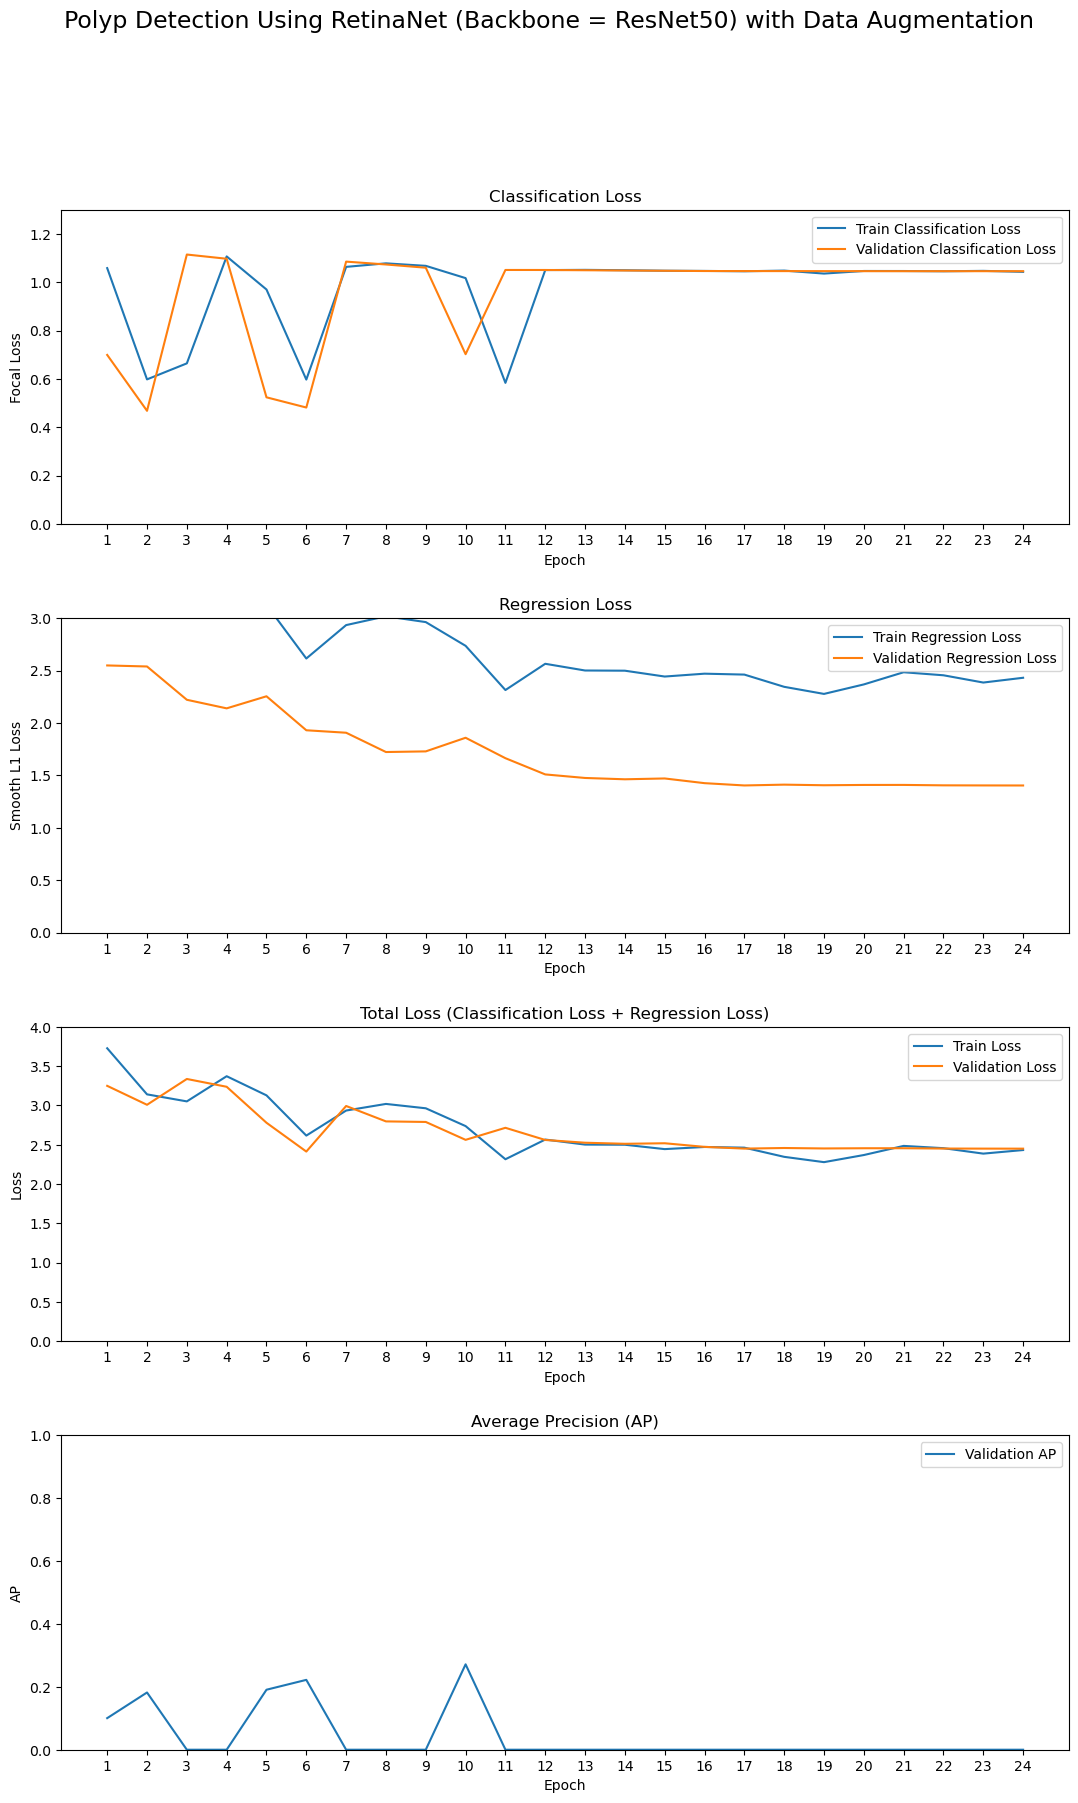

In [19]:
fig = r'C:\Users\Asus\Desktop\retinanet_resnet50_aug.png'
plot_history(history_aug, fig, 'Polyp Detection Using RetinaNet (Backbone = ResNet50) with Data Augmentation', epochs)